In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label,sum_labels
from scipy.signal import savgol_filter
import os, pickle

In [2]:
def convert_bool_to_binary(bool_array):
    return copy.copy(np.array(bool_array,"int"))

def column_dilation(array):
    zeors = np.zeros((array.shape[0],array.shape[1]*2))
    zeors[:,list(range(0,zeors.shape[1],2))] = array
    return zeors

def interpolate_data(array,undetected_bool,period=None):
    array = copy.copy(array)
    for col in range(array.shape[1]):
        fp = array[:,col]
        xp = np.arange(len(fp))
        cells_to_interpolate = undetected_bool[:,col]
        fp_nonan = fp[np.invert(cells_to_interpolate)]
        xp_nonan = xp[np.invert(cells_to_interpolate)]
        if period is not None:
            array[:,col] = np.interp(xp, xp_nonan, fp_nonan, period=period)
        else: array[:,col] = np.interp(xp, xp_nonan, fp_nonan)
    return array

def find_cells_to_interpolate(array):
    undetected_springs_bool = np.isnan(array)
    undetected_springs_for_long_time = filter_continuity(convert_bool_to_binary(undetected_springs_bool),min_size=8)
    cells_to_interpolate = copy.copy(undetected_springs_bool)
    cells_to_interpolate[undetected_springs_for_long_time] = False
    return cells_to_interpolate

def filter_continuity(binary_array,min_size=0,max_size=np.inf):
    binary_array_dilated = column_dilation(binary_array)
    labeled,labels = label(binary_array_dilated)
    labels = np.arange(labels+1)[1:]
    labeled_summed = sum_labels(binary_array_dilated,labeled,index=labels).astype(int)
    labels_to_remove = labels[np.invert((labeled_summed>min_size)&(labeled_summed<max_size))]
    labeled[np.isin(labeled,labels_to_remove)]=0
    labeled = labeled[:,list(range(0,labeled.shape[1],2))]
    return labeled>=1

In [3]:
class Prepare_data:
    def __init__(self,directory,save_events=False):
        self.directory = directory
        self.load_data(directory)
        self.original_N_ants = copy.copy(self.N_ants_around_springs)
        self.load_starting_frame()
        self.N_ants_proccessing()
        self.springs_length_processing()
        self.springs_angles_processing()
        self.angular_velocity_nest = self.calc_angular_velocity(self.springs_angles_to_nest)
        self.springs_rest_lengths()
        self.attaches_events(self.N_ants_around_springs)
        self.labeled_zero_to_one_filtered = self.fiter_attaches_events(self.labeled_zero_to_one)
        # if save_events:
        #     self.save_events(self.labeled_zero_to_one_filtered,self.directory)

    def load_data(self,directory):
        self.N_ants_around_springs = np.loadtxt(f"{directory}N_ants_around_springs.csv",delimiter=",")
        self.size_ants_around_springs = np.loadtxt(f"{directory}size_ants_around_springs.csv",delimiter=",")
        self.springs_length = np.loadtxt(f"{directory}springs_length.csv",delimiter=",")
        self.springs_angles_to_nest = np.loadtxt(f"{directory}springs_angles_to_nest.csv",delimiter=",")
        self.springs_angles_to_object = np.loadtxt(f"{directory}springs_angles_to_object.csv",delimiter=",")

    def load_starting_frame(self):
        path_parts =  os.path.normpath(self.directory).split('\\')
        with open(os.path.join("Z:/Dor_Gabay/ThesisProject/data/videos",path_parts[-3],"video_preferences.pickle"), 'rb') as handle:
            # self.startig_frame = pickle.load(handle)["Z:\\Dor_Gabay\\videos\\10.9\\plus0_force\\S5200007.MP4"]['starting_frame']
            path = f"Z:\\Dor_Gabay\\videos\\{path_parts[-3]}\\{path_parts[-2]}\\{path_parts[-1]}.MP4"
            self.starting_frame = pickle.load(handle)[path]['starting_frame']
            print("starting_frame:",self.startig_frame)

    def N_ants_proccessing(self):
        undetected_springs_for_long_time = filter_continuity(convert_bool_to_binary(np.isnan(self.springs_length)),min_size=8)
        self.N_ants_around_springs = np.round(interpolate_data(self.N_ants_around_springs,find_cells_to_interpolate(self.N_ants_around_springs)))
        self.N_ants_around_springs[np.isnan(self.N_ants_around_springs)] = 0
        self.N_ants_around_springs = self.smoothing_n_ants(self.N_ants_around_springs)
        self.N_ants_around_springs[undetected_springs_for_long_time] = np.nan
        all_small_attaches = np.zeros(self.N_ants_around_springs.shape,int)
        for n in np.unique(self.N_ants_around_springs)[1:]:
            if not np.isnan(n):
                short_attaches = filter_continuity(self.N_ants_around_springs==n,max_size=30)
                all_small_attaches[short_attaches] = 1
        self.N_ants_around_springs = np.round(interpolate_data(self.N_ants_around_springs,all_small_attaches.astype(bool)))

    def springs_length_processing(self):
        self.springs_length_processed = copy.copy(self.springs_length)
        # self.springs_length_processed[np.invert(np.isnan(self.springs_length))&np.isnan(self.springs_length)]=0
        self.springs_length_processed = interpolate_data(self.springs_length_processed,find_cells_to_interpolate(self.springs_length))

    def springs_angles_processing(self):
        cells_to_interp = find_cells_to_interpolate(self.springs_angles_to_nest)
        self.springs_angles_to_nest = interpolate_data(self.springs_angles_to_nest+np.pi, cells_to_interp,period=2*np.pi)
        self.springs_angles_to_object = interpolate_data(self.springs_angles_to_nest+np.pi, cells_to_interp,period=2*np.pi)

    def calc_angular_velocity(self,angles):
        diff = np.diff(angles,axis=0)
        diff[diff>np.pi] = diff[diff>np.pi]-2*np.pi
        return diff

    def smoothing_n_ants(self, array):
        for col in range(array.shape[1]):
            array[:,col] = np.abs(np.round(savgol_filter(array[:,col], 31, 2)))
        return array

    def attaches_events(self,N_ants_array):
        N_ants_array = copy.copy(N_ants_array)
        N_ants_array = column_dilation(N_ants_array)
        diff = np.vstack((np.diff(N_ants_array,axis=0),np.zeros(N_ants_array.shape[1]).reshape(1,N_ants_array.shape[1])))
        labeled_single_attaches,num_labels_single = label(convert_bool_to_binary(N_ants_array==1))
        labeled_single_attaches_adapted = np.vstack((labeled_single_attaches,np.zeros(labeled_single_attaches.shape[1]).reshape(1,labeled_single_attaches.shape[1])))[1:,:]
        labels_0_to_1 = np.unique(labeled_single_attaches_adapted[(diff==1)&(N_ants_array==0)])
        labels_1_to_0 = np.unique(labeled_single_attaches_adapted[(diff==-1)&(N_ants_array==1)])
        self.labeled_zero_to_one,_ = label(np.isin(labeled_single_attaches,labels_0_to_1))
        self.labeled_zero_to_one = self.labeled_zero_to_one[:,list(range(0,self.labeled_zero_to_one.shape[1],2))]
        self.labeled_one_to_zero,_ = label(np.isin(labeled_single_attaches,labels_1_to_0))
        self.labeled_one_to_zero = self.labeled_one_to_zero[:,list(range(0,self.labeled_one_to_zero.shape[1],2))]

    def fiter_attaches_events(self, labeled):
        EVENT_LENGTH = 150
        PRE_EVENT_LENGTH = 15
        ar = self.labeled_zero_to_one
        events_to_keep = []
        self.events_sts = []
        for event in np.unique(ar):
            frames = np.where(ar[:,:]==event)[0]
            # print(event,":",len(frames))
            pre_frames = np.arange(frames[0]-PRE_EVENT_LENGTH,frames[0]-1,1)
            spring = np.where(ar[:,:]==event)[1][0]
            # if len(frames)>EVENT_LENGTH:
            if True:
                if np.sum(np.isnan(self.N_ants_around_springs[frames[0]-10:frames[0],spring]))==0:
                    pre_frames_lengths = np.take(self.springs_length_processed[:,spring],pre_frames)
                    pre_frames_median = np.nanmedian(pre_frames_lengths)
                    # if (not pre_frames_median<self.rest_length*0.8) & (not pre_frames_median>self.rest_length*1.2):
                    if True:
                        self.events_sts.append(np.nanstd(pre_frames_lengths)/pre_frames_median)
                        # if not np.std()
                        events_to_keep.append(event)
        labeled = copy.copy(labeled)
        labeled[np.invert(np.isin(labeled,events_to_keep))] = 0
        labeled = column_dilation(labeled)
        labeled, _ =  label(labeled!=0)
        labeled = labeled[:,list(range(0,labeled.shape[1],2))]
        # print(.shape)
        return labeled

    def clean_ant_switching(self,N_ants_array):
        N_ants_array = copy.copy(N_ants_array)
        N_ants_array = column_dilation(N_ants_array)
        labeled_all_attaches,num_labels_all = label(convert_bool_to_binary(N_ants_array>=1))

        labels_to_remove = np.unique(labeled_all_attaches[N_ants_array>1&np.isnan(N_ants_array)])
        N_ants_array[np.isin(labeled_all_attaches,labels_to_remove)] = 0
        N_ants_array = N_ants_array[:,list(range(0,N_ants_array.shape[1],2))]
        return N_ants_array

    def filter_by_ant_size(self):
        from scipy.ndimage import median
        self.size_ants_around_springs[np.isnan(self.size_ants_around_springs)] = 0
        N_ants_for_mean = copy.copy(self.N_ants_around_springs)
        N_ants_for_mean[self.size_ants_around_springs==0] = 0
        median_size_over_N_ants = median(self.size_ants_around_springs,N_ants_for_mean.astype(int),index=np.unique(N_ants_for_mean))
        # size_ants_around_springs[(smoothed_N_ants_without_short_attaches==1)&size_ants_around_springs*1.3<median_size_over_N_ants[1]] = 0
        false_single_ants = (self.N_ants_around_springs==1)&(self.size_ants_around_springs>median_size_over_N_ants[1]*1.5)

    def springs_rest_lengths(self):
        ar = copy.copy(self.springs_length_processed)
        ar[self.N_ants_around_springs!=0] = np.nan
        ar = np.sort(ar,axis=0)
        self.rest_lenghts = np.nanmedian(ar[:100],axis=0)
        self.rest_length = np.median(self.rest_lenghts)

    def events_hist(self):
        number_of_seconds = sum_labels(convert_bool_to_binary(self.single_ant_attached_labeled>=1),self.single_ant_attached_labeled,np.unique(self.single_ant_attached_labeled))/50
        plt.hist(number_of_seconds,bins=100)
        plt.show()

    # def save_events(self,labeled_events,output_dir):
    #     events = np.unique(labeled_events)[1:]
    #     events_array = np.zeros((len(events),4),"int")
    #     for event in events:
    #         spring = np.where(labeled_events[:,:]==event)[1][0]
    #         frames = np.where(labeled_events[:,:]==event)[0]
    #         start_frame, end_frame = frames[0]+self.startig_frame,frames[-1]+self.startig_frame
    #         events_array[event-1,:] = event,spring,start_frame,end_frame
    #     headers = 'event_num,spring,start,end'
    #     np.savetxt(output_dir + '/single_ants_events.csv', events_array, delimiter=',',header=headers)

In [42]:
plus0 = Prepare_data("Z:/Dor_Gabay/ThesisProject/data/videos_analysis_data/10.9/plus0_force/S5200007/")
plus01 = Prepare_data("Z:/Dor_Gabay/ThesisProject/data/videos_analysis_data/10.9/plus0.1_force/S5200005/")
plus03 = Prepare_data("Z:/Dor_Gabay/ThesisProject/data/videos_analysis_data/15.9.22/plus0.3mm_force/S5280009/")
plus05 = Prepare_data("Z:/Dor_Gabay/ThesisProject/data/videos_analysis_data/18.9.22/plus0.5mm_force/S5290002/")

startig_frame: 75
startig_frame: 0
startig_frame: 0
startig_frame: 0


In [44]:
import pandas as pd
import seaborn as sb
def plot_velocity_to_n_ants(data):
    total_n_ants = np.nansum(data.N_ants_around_springs,axis=1)[:-1]
    median_velocity = np.abs(np.nanmedian(data.angular_velocity_nest,axis=1))
    n_ants_to_velocity = pd.DataFrame({"total_n_ants":total_n_ants,"median_velocity":median_velocity})
    n_ants_to_velocity = n_ants_to_velocity.sort_values("total_n_ants")
    sb.lineplot(n_ants_to_velocity,y="median_velocity",x="total_n_ants")
    plt.show()
    plt.clf()

C:\Users\dorg\.conda\envs\DorConda\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


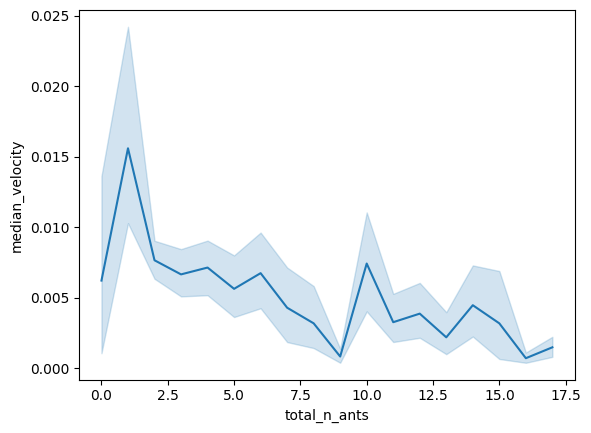

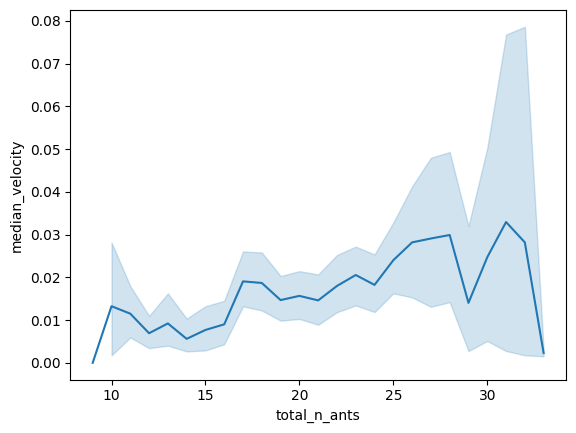

C:\Users\dorg\.conda\envs\DorConda\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


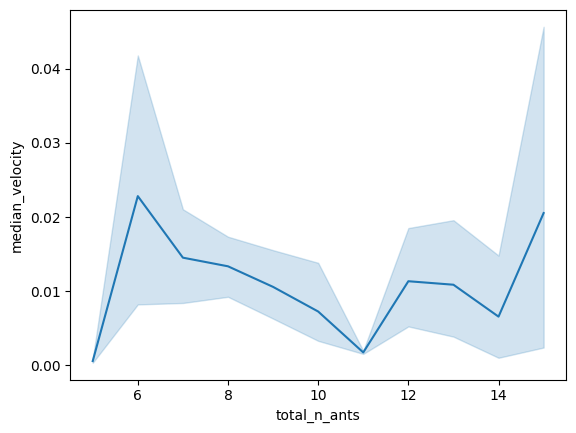

C:\Users\dorg\.conda\envs\DorConda\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


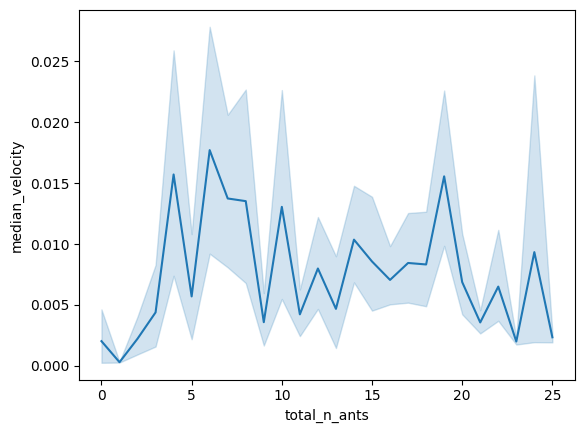

<Figure size 640x480 with 0 Axes>

In [45]:
for data in [plus0,plus01,plus03,plus05]:
    plot_velocity_to_n_ants(data)

In [16]:
def mean_velocity(array):
    roll = rolling_average(np.nanmedian(array,axis=1),20)
    print("array.shape: ",array.shape)
    print("roll.shape: ",roll.shape)
    return np.nanmean(np.abs(roll))

def rolling_average(data, window_size):
    """Compute the rolling average of the given data over the specified window size."""
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

plus0_veloc_avg = mean_velocity(plus0)
plus01_veloc_avg = mean_velocity(plus01)
plus03_veloc_avg = mean_velocity(plus03)
plus05_veloc_avg = mean_velocity(plus05)

array.shape:  (13046, 20)
roll.shape:  (13046,)
array.shape:  (42099, 20)
roll.shape:  (42099,)
array.shape:  (7899, 20)
roll.shape:  (7899,)
array.shape:  (49960, 20)
roll.shape:  (49960,)


C:\Users\dorg\.conda\envs\DorConda\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [18]:
np.nanmedian(plus0,axis=1)

C:\Users\dorg\.conda\envs\DorConda\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


array([-5.47805125e-05,  3.23270510e-03,  5.35086804e-03, ...,
       -1.32052422e-04, -8.66189973e-04, -3.45009217e-03])

In [17]:
rolling_average(np.nanmedian(plus0,axis=1),20)

C:\Users\dorg\.conda\envs\DorConda\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


array([ 0.00041974,  0.00030708,  0.00036083, ..., -0.00027359,
       -0.0002487 , -0.0002487 ])

In [15]:
print(plus0_veloc_avg,plus01_veloc_avg,plus03_veloc_avg,plus05_veloc_avg)

0.0009431503988031868 0.013368212477172167 0.0029426986885908073 0.003919204015703519


[37, 41, 59, 83, 87]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118]
video_analysis_starting_frame:  75
start_frame:  13010
end_frame:  13121


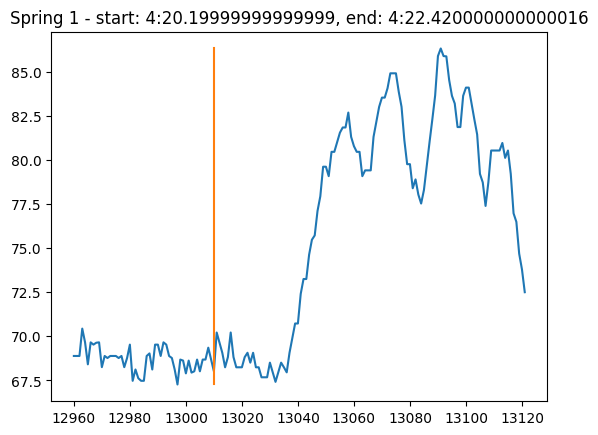

In [51]:
n= 118
a = files.labeled_zero_to_one_filtered
print([x for x in np.unique(a)[1:] if (np.where(a[:,:]==x)[1][0]==11)&(np.where(a[:,:]==x)[0][0]>3900)])
print(np.unique(a)[1:])
frames_ori = np.where(a[:,:]==n)[0]
x = np.append(np.arange(frames_ori[0]-50,frames_ori[0]-1,1),frames_ori)
spring = np.where(a[:,:]==n)[1][0]
y = files.springs_length_processed[:,spring]
y = np.take(y,x)
x = x+files.startig_frame
print("video_analysis_starting_frame: ",files.starting_frame)
plt.plot(x,y)
plt.plot(np.repeat(frames_ori[0]+files.startig_frame,len(x)),np.linspace(np.nanmin(y),np.nanmax(y),len(x)))
start_frame, end_frame = frames_ori[0]+files.startig_frame,frames_ori[-1]+files.startig_frame
start_min, end_min = int(start_frame/50//60),int(end_frame/50//60)
start_sec, end_sec = start_frame/50-60*start_min,end_frame/50-60*start_min

print("start_frame: ",start_frame)

print("end_frame: ",end_frame)
plt.title(f"Spring {spring} - start: {start_min}:{start_sec}, end: {end_min}:{end_sec}")
# plt.ylim((0,40))
plt.show()